Постановка задачи: сравнить результаты нескольких рекламных кампаний (не менее 3, оптимально - 5-7) по двум или более метрикам. Предпочтительно, чтобы каждая рекламная кампания включала не менее двух объявлений. Целевая функция и метрики могут быть определены как на стороне компании, так и самостоятельно. При самостоятельном определении целевой функции и соответствующих метрик необходимо представить обоснование выбора. 

Мы подготовили результаты трех рекламных кампаний.
Все были взяты из открытых источников.

In [1]:
# модули, которые будут использованы
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# объявим все датасеты
df_1 = pd.read_csv("1st_campaign.csv")
df_2 = pd.read_csv("2nd_campaign.csv")
df_3 = pd.read_csv("3rd_campaign.csv")

In [3]:
# посмотрим информацию по каждому из датасетов
df_1.info(), df_2.info(), df_3.info()
df_3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         318 non-null    object 
 1   campaign     318 non-null    object 
 2   adgroup      318 non-null    object 
 3   ad           318 non-null    object 
 4   cost         318 non-null    float64
 5   impressions  318 non-null    int64  
 6   clicks       318 non-null    int64  
 7   conversions  318 non-null    int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 20.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4571 entries, 0 to 4570
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         4571 non-null   object 
 1   campaign     4571 non-null   object 
 2   adgroup      4571 non-null   object 
 3   ad           4571 non-null   object 
 4   impressions  4571 non-null   int64  
 5   clicks  

,date,campaign,adgroup,ad,cost,impressions,clicks,conversions
0,01-03-2021,campaign 1,adgroup 1,ad 1,0.603,120.977,49,1
1,01-03-2021,campaign 1,adgroup 3,ad 1,0.193,21.977,12,0
2,01-03-2021,campaign 1,adgroup 4,ad 1,0.073,4.977,3,0
3,01-03-2021,campaign 1,adgroup 2,ad 1,0.033,1.977,1,0
4,01-03-2021,campaign 1,adgroup 2,ad 2,0.033,2.977,1,0


Для того, чтобы было удобно работать с датасетами, приведем их к одному формату и объеденим

In [4]:
df_2 = df_2.drop('revenue', axis=1)  # удаляем столбец revenue из второго датасета
df_2['campaign'] = 'campaign 2'
df_3['campaign'] = 'campaign 3'

df = pd.concat([df_1, df_2, df_3], ignore_index=True)
df

,date,campaign,adgroup,ad,cost,impressions,clicks,conversions
0,01-03-2021,campaign 1,adgroup 1,ad 1,0.580,121.000,49,1
1,01-03-2021,campaign 1,adgroup 3,ad 1,0.170,22.000,12,0
2,01-03-2021,campaign 1,adgroup 4,ad 1,0.050,5.000,3,0
3,01-03-2021,campaign 1,adgroup 2,ad 1,0.010,2.000,1,0
4,01-03-2021,campaign 1,adgroup 2,ad 2,0.010,3.000,1,0
...,...,...,...,...,...,...,...,...
5202,15-03-2021,campaign 3,adgroup 4,ad 55,0.033,0.977,1,0
5203,15-03-2021,campaign 3,adgroup 3,ad 55,0.033,4.977,1,0
5204,15-03-2021,campaign 3,adgroup 1,ad 55,0.163,24.977,11,0
5205,15-03-2021,campaign 3,adgroup 3,ad 56,0.083,8.977,4,0


Визуально представим данные с датасетов

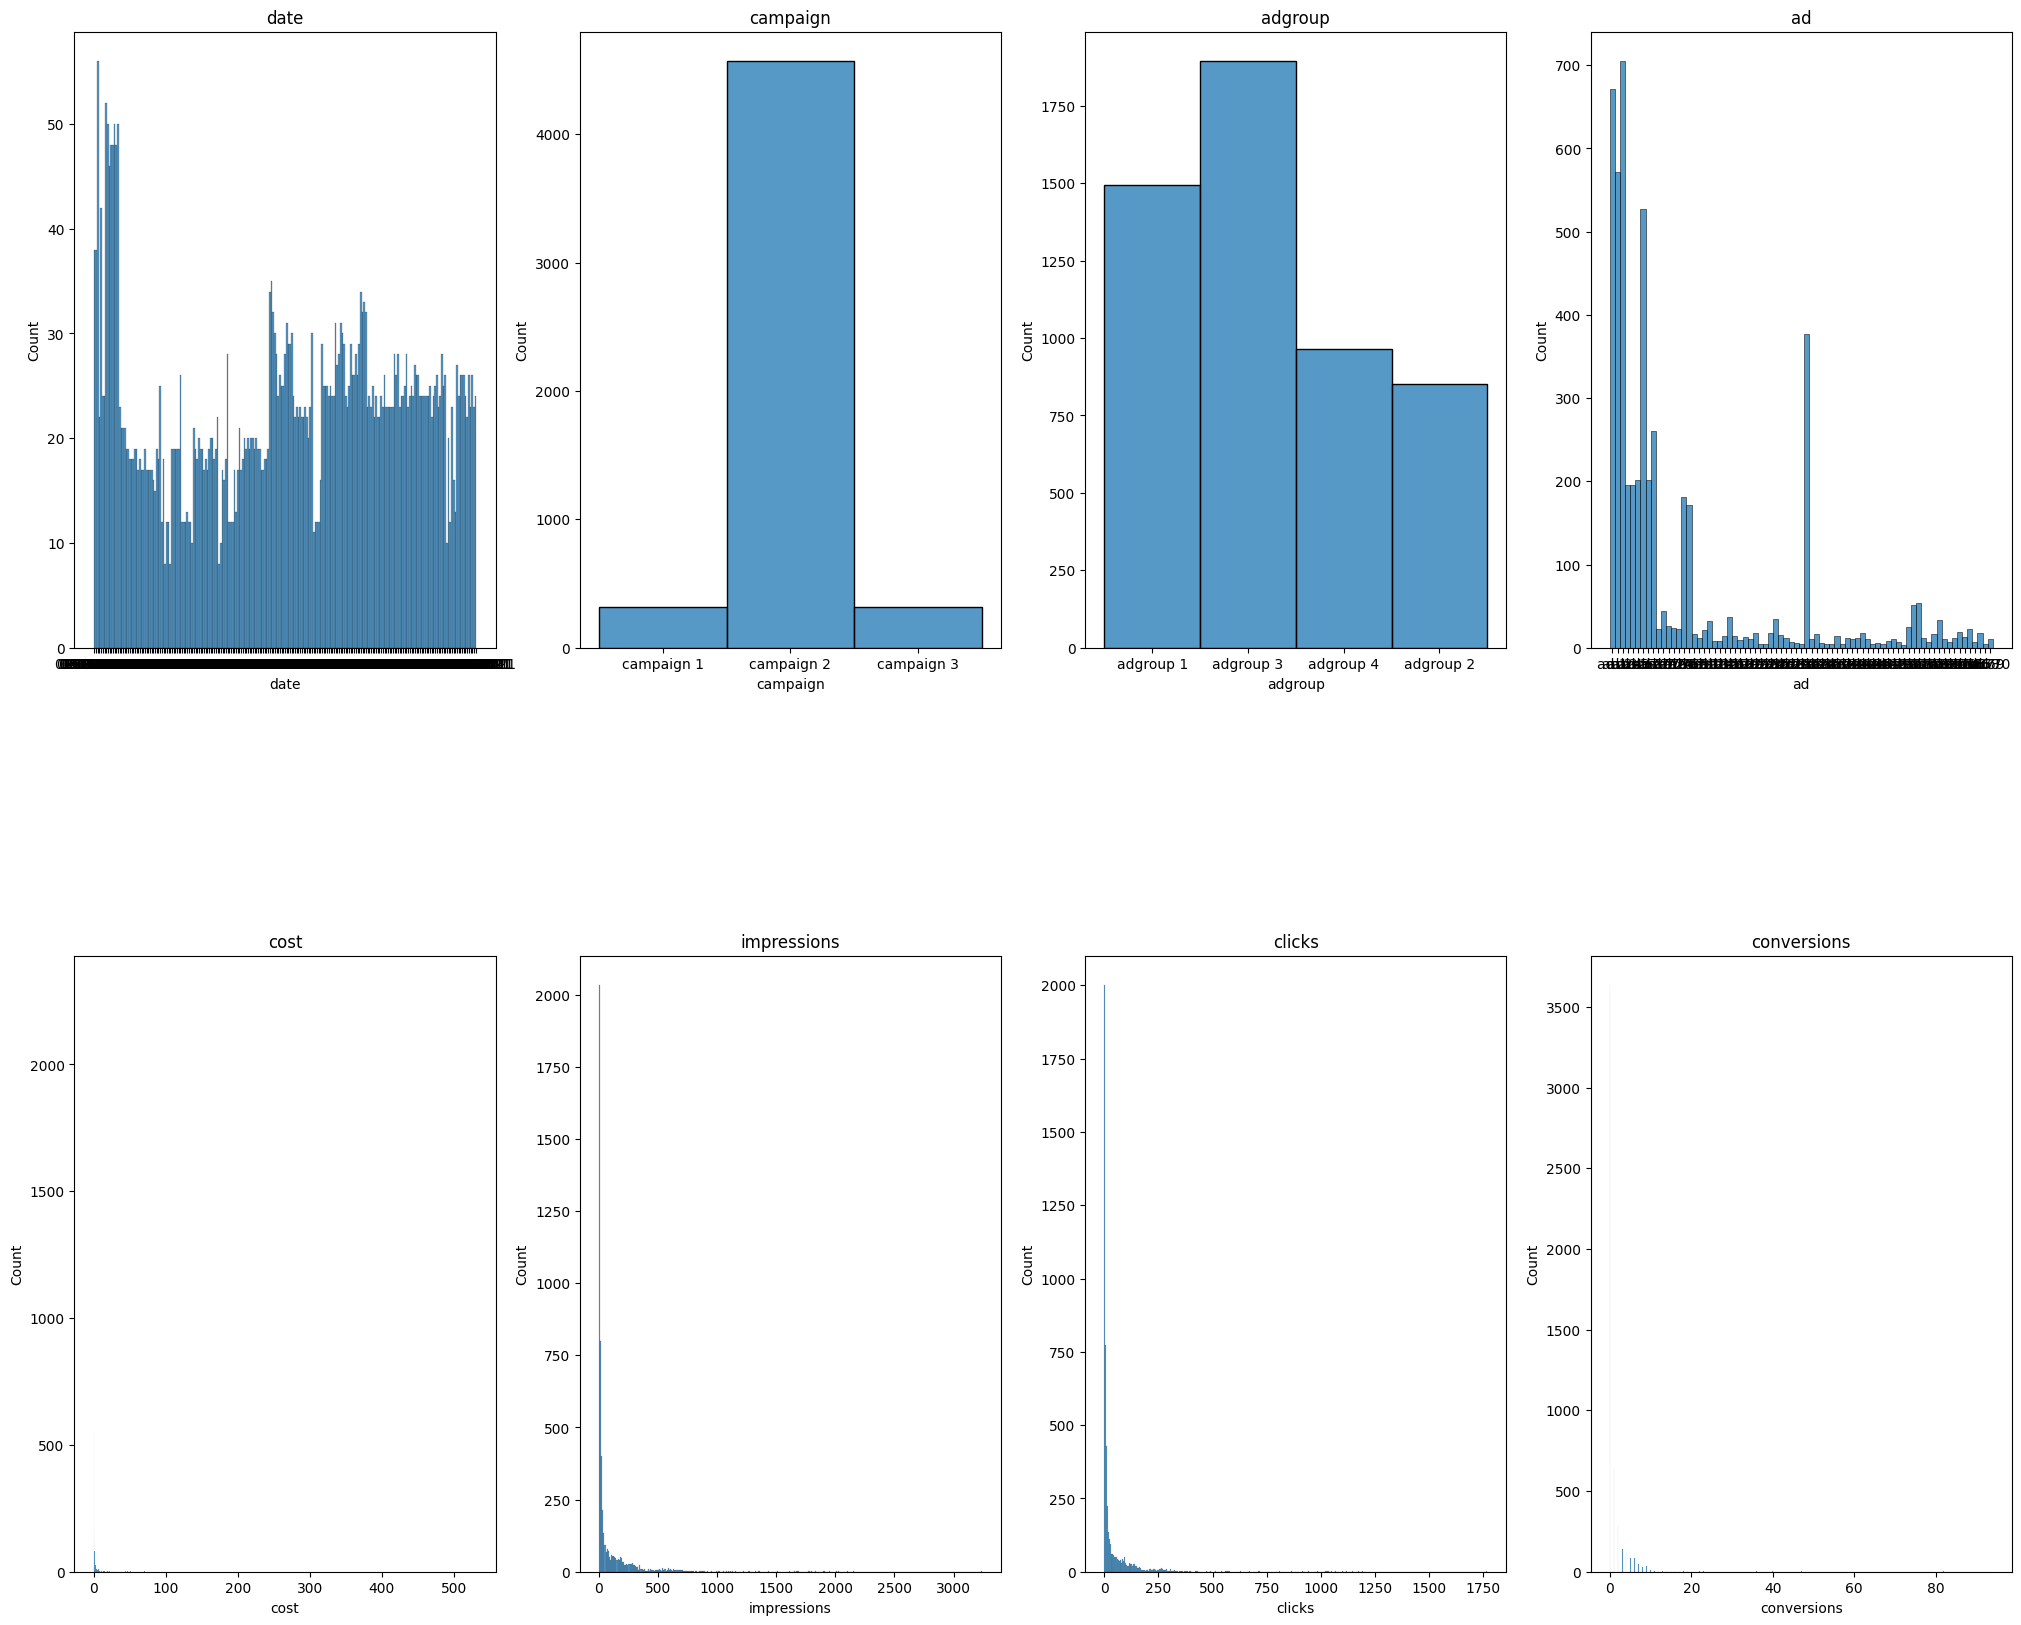

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(25, 20))
for i, ax in zip(df.columns, axes.flat):
    sns.histplot(df[i], ax=ax)
    ax.set_title(i)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Также для более детального анализа данных и для выявления основных свойств датасета, включая распределения и корреляции между переменными, воспользуемся следующим методом:

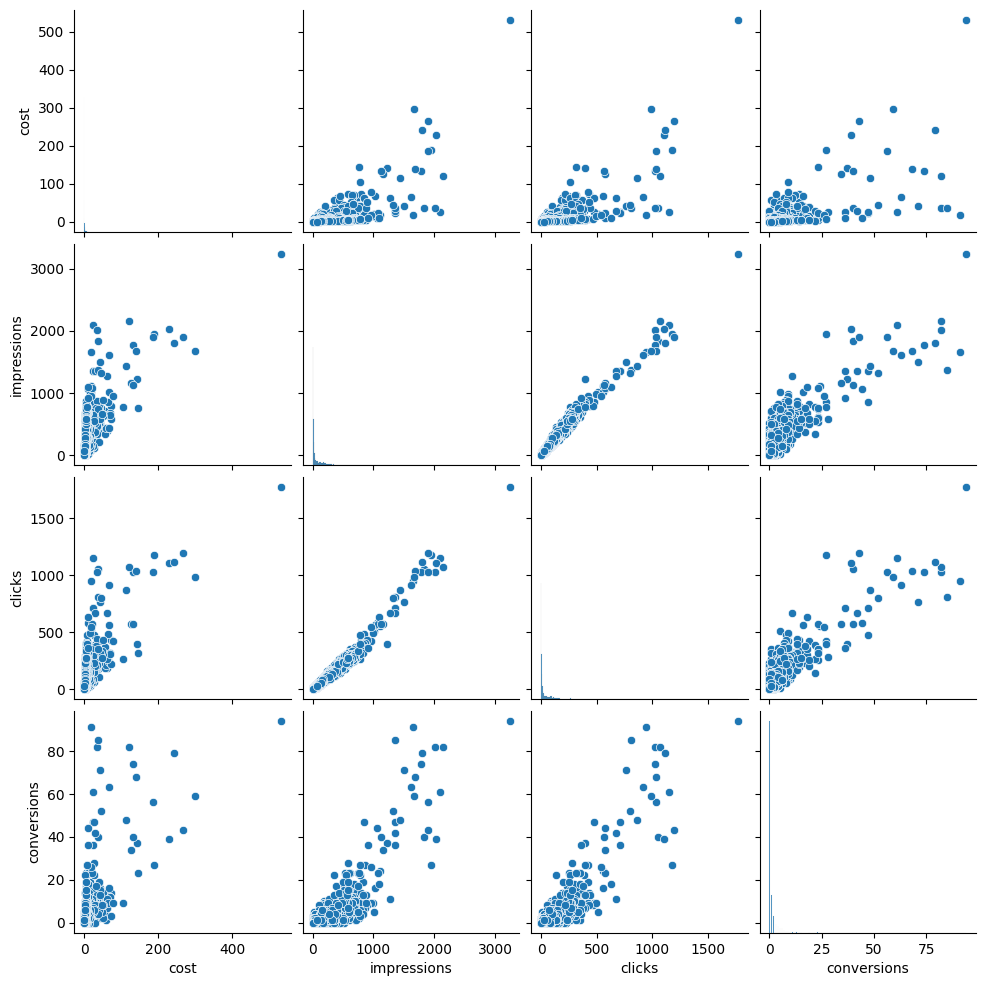

In [6]:
sns.pairplot(df)

Целевая функция: привлечение целевой аудитории для знакомства с продуктом.

Мы будем сравнивать рекламные кампании по следующим метрикам:
1. CTR (click-through rate) - отношение количества кликов к количеству показов.2. 
CPC (cost per click) - средняя стоимость клика.

In [7]:
# рассчитаем CTR и CPC для каждой рекламной кампании 
def calculate_metrics(ad_data):
    """
    Рассчитывает метрики CTR (Click-Through Rate) и CPC (Cost Per Click) для датафрейма рекламных данных.

    Args:
        df (DataFrame): Датафрейм рекламных данных, содержащий колонки 'clicks' и 'impressions', 'cost'.

    Returns:
        DataFrame: Обновленный датафрейм с добавленными колонками 'CTR' и 'CPC'.
    """
    ad_data = ad_data[ad_data['clicks'] != 0]  # избегаем деления на ноль
    ad_data = ad_data[ad_data['impressions'] != 0]  # избегаем деления на ноль

    ad_data['CTR'] = ad_data['clicks'] / ad_data['impressions'] * 100  # в процентах 
    ad_data['CPC'] = ad_data['cost'] / ad_data['clicks'] * 100  # в процентах 
    return ad_data


df = calculate_metrics(df)

In [8]:
# Функция для сравнения кампаний
def compare_campaigns(df):
    """
    Сравнивает различные рекламные кампании на основе суммарных и средних значений метрик,
    таких как стоимость, показы, клики, конверсии, CTR и CPC.

    Args:
        df (DataFrame): Датафрейм, содержащий данные рекламных кампаний, с колонками
                        'campaign', 'cost', 'impressions', 'clicks', 'conversions',
                        'CTR' и 'CPC'.

    Returns:
        DataFrame: Датафрейм с агрегированными метриками по каждой рекламной кампании.
    """
    campaign_summary = df.groupby('campaign').agg({
        'cost': 'sum',
        'impressions': 'sum',
        'clicks': 'sum',
        'conversions': 'sum',
        'CTR': 'mean',
        'CPC': 'mean'
    }).reset_index()
    print(campaign_summary)
    return campaign_summary


agg_df = compare_campaigns(df)

     campaign       cost  impressions  clicks  conversions        CTR  \
0  campaign 1    121.270    21283.000    9451          256  50.092361   
1  campaign 2  12802.610   422608.000  198111         6121  48.726416   
2  campaign 3    127.756    21276.514    9451          256  50.327532   

        CPC  
0  1.328347  
1  6.538095  
2  1.888594  


Можем сравнить все датасеты по полученным результатам

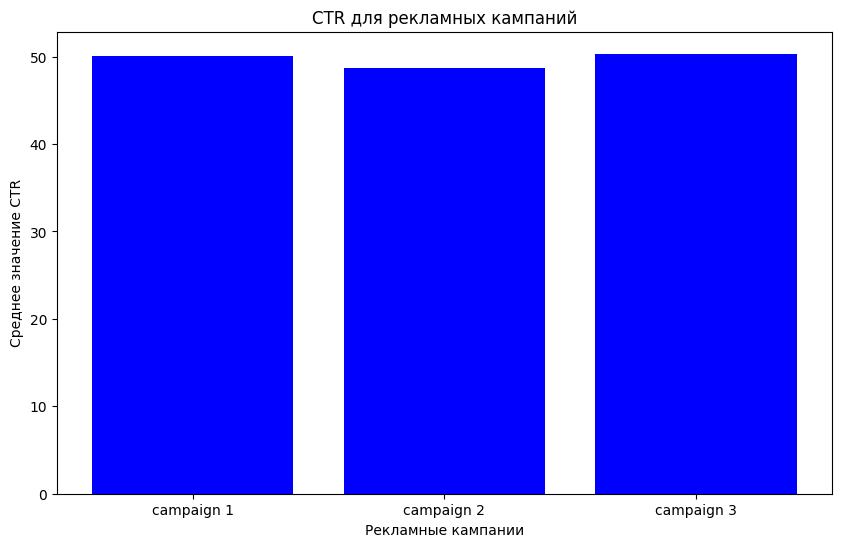

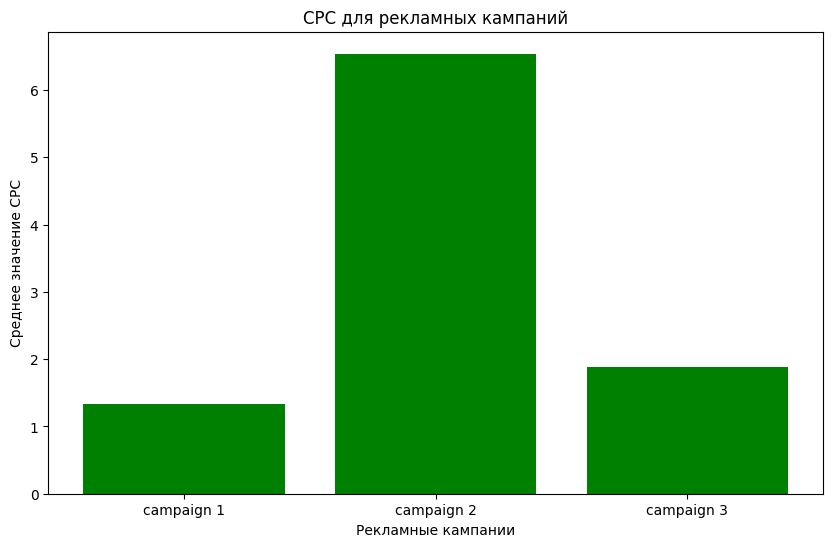

In [9]:
# Визуализация
def visualisation_CPC_CTR(df):
    """
    Визуализирует средние значения CTR (Click-Through Rate) и CPC (Cost Per Click)
    для каждой рекламной кампании в датафрейме.

    Построение выполняется с использованием столбчатых диаграмм, где каждая кампания
    отображается по оси X, а значения CTR и CPC по оси Y.

    Args:
        df (DataFrame): Датафрейм с колонками 'campaign', 'CTR', и 'CPC', где каждая строка
                        содержит данные по одной кампании.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(df['campaign'], df['CTR'], color='blue')
    plt.xlabel('Рекламные кампании')
    plt.ylabel('Среднее значение CTR')
    plt.title('CTR для рекламных кампаний')
    plt.show()
    # plt.bar(data['product'], data['CTR'])
    plt.figure(figsize=(10, 6))
    plt.bar(df['campaign'], df['CPC'], color='green')
    plt.xlabel('Рекламные кампании')
    plt.ylabel('Среднее значение CPC')
    plt.title('CPC для рекламных кампаний')
    plt.show()


visualisation_CPC_CTR(agg_df)

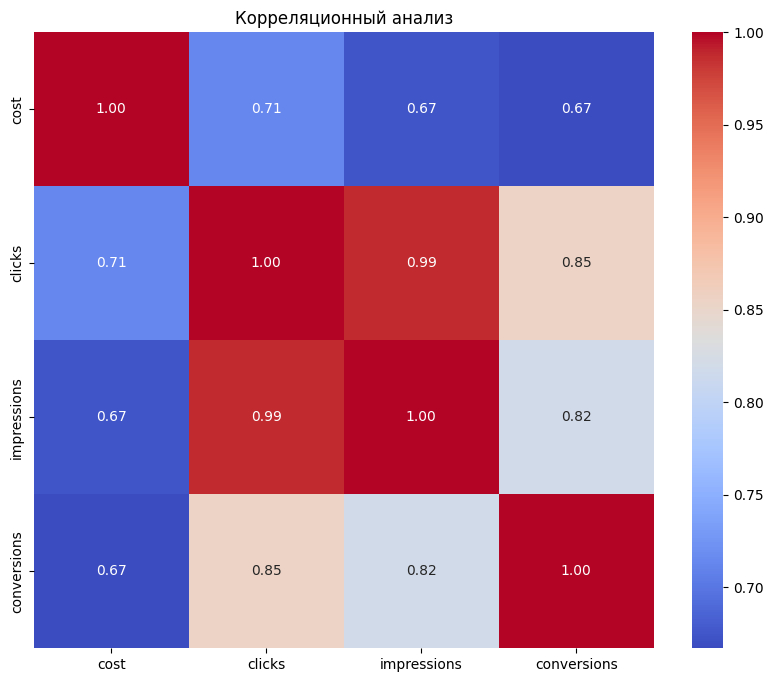

In [10]:
# функция для расчета корреляции
def analyze_correlations(df):
    """
    Анализирует корреляцию между различными метриками рекламной кампании и визуализирует
    корреляционную матрицу с помощью тепловой карты.

    Args:
        df (DataFrame): Датафрейм, содержащий метрики рекламной кампании, включая 'cost',
                        'clicks', 'impressions', 'CTR', 'CPC' и 'conversions'.
    """

    correlation_matrix = df[['cost', 'clicks', 'impressions', 'conversions']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title('Корреляционный анализ')
    plt.show()


analyze_correlations(df)

Воспользуемся регрессией для анализа так как:
1. Регрессионный анализ позволяет количественно оценить влияние каждого из факторов на результат. Это может помочь определить, насколько сильно изменение одного из параметров повлияет на итоговые показатели.2.  С помощью регрессионного анализа можно выявить, какие переменные значимо влияют на результат, и какие можно исключить из рассмотрения при планировании кампаний.

In [11]:
# Функция для регрессионного анализа
def perform_regression(df):
    """
    Выполняет регрессионный анализ для определения влияния затрат, показов, кликов,
    CTR и CPC на количество конверсий.

    args: df (DataFrame): Датафрейм, содержащий зависимую переменную 'conversions'
            и независимые переменные 'cost', 'impressions', 'clicks', 'CTR', 'CPC'.
    """
    # Зависимая переменная
    y = df['conversions']
    # Независимые переменные
    X = df[['cost', 'impressions', 'clicks', 'CTR', 'CPC']]
    X = sm.add_constant(X)  # добавляем константу для перехвата

    model = sm.OLS(y, X).fit()
    print(model.summary())


perform_regression(df)

                            OLS Regression Results                            
Dep. Variable:            conversions   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     2905.
Date:                Mon, 06 May 2024   Prob (F-statistic):               0.00
Time:                        00:18:06   Log-Likelihood:                -11065.
No. Observations:                4691   AIC:                         2.214e+04
Df Residuals:                    4685   BIC:                         2.218e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1827      0.110     -1.668      

Опишем процесс обучения модели линейной регрессии и оценки её качества с использованием метрик среднеквадратичной ошибки (MSE) и коэффициента детерминации (R²).

In [12]:
# готовим датафрейм для прогнозирования числовых показателей с помощью библиотеки sklearn и поиска корреляционных зависимостей
df = df.drop(['date', 'campaign', 'adgroup', 'ad'], axis=1)

# Разделяем данные на признаки и целевую переменную
X = df.drop('conversions', axis=1)  # предсказываем поведение conversions
y = df['conversions']

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаём и обучаем модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Сделать предсказания на тестовом наборе
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Поиск корреляционных зависимостей
correlation_matrix = df.corr()
print(correlation_matrix)

Mean Squared Error: 9.409011774572411
R^2 Score: 0.7420582651472366
                 cost  impressions    clicks  conversions       CTR       CPC
cost         1.000000     0.674137  0.713085     0.667045  0.006896  0.145989
impressions  0.674137     1.000000  0.987149     0.819112 -0.058399 -0.002532
clicks       0.713085     0.987149  1.000000     0.854628 -0.019116  0.002412
conversions  0.667045     0.819112  0.854628     1.000000  0.003600  0.021334
CTR          0.006896    -0.058399 -0.019116     0.003600  1.000000  0.058706
CPC          0.145989    -0.002532  0.002412     0.021334  0.058706  1.000000


так как r^2 ближе к 1, то это значит, что модель имеет хорошее соответстивик данных 

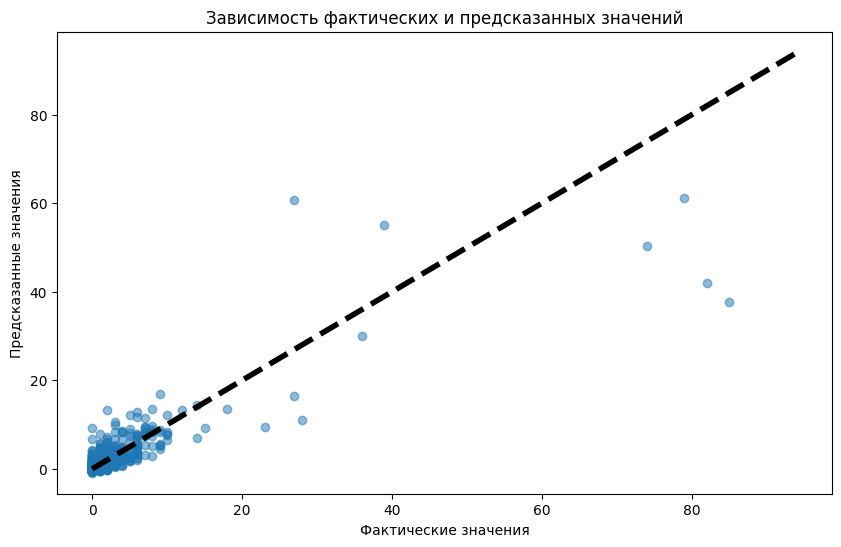

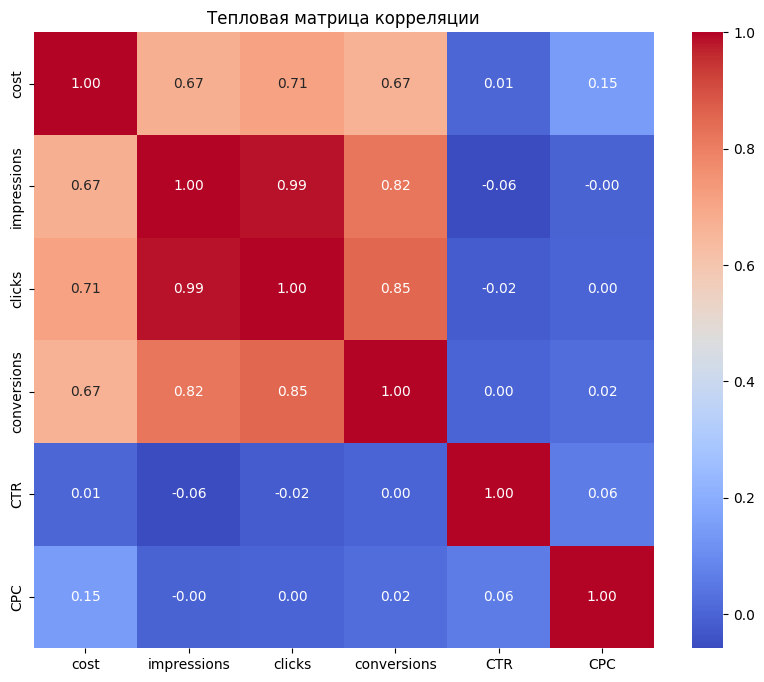

In [13]:
# Визуализация фактических значений по сравнению с предсказанными значениями
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Зависимость фактических и предсказанных значений')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Линия идеального предсказания
plt.show()

# Тепловая карта корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Тепловая матрица корреляции')
plt.show()

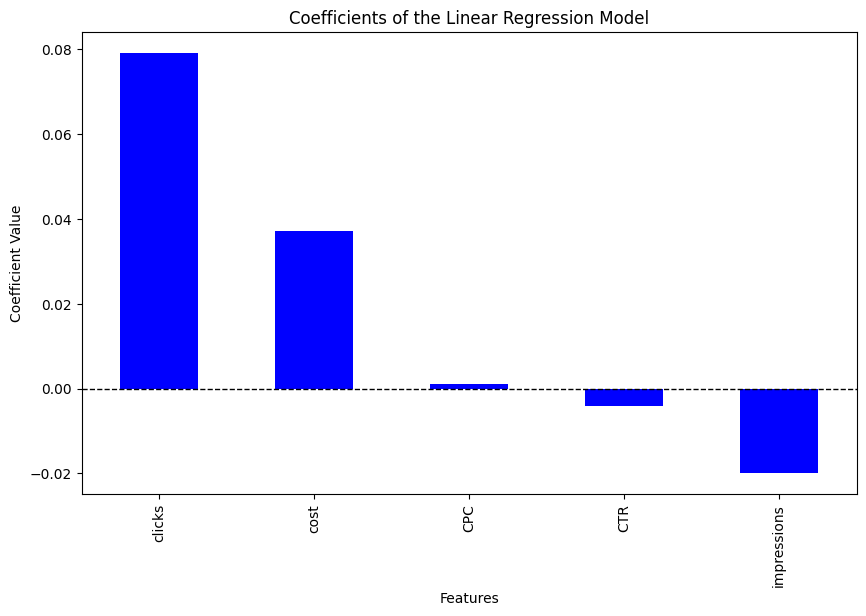

In [14]:
# Получение коэффициентов модели
coefficients = model.coef_

# Создание DataFrame для визуализации
coef_df = pd.DataFrame(coefficients, X_train.columns, columns=['Coefficient'])

# Сортировка значений по величине коэффициентов
coef_df = coef_df.sort_values('Coefficient', ascending=False)

# Визуализация коэффициентов модели
plt.figure(figsize=(10, 6))
coef_df['Coefficient'].plot(kind='bar', color='blue')
plt.title('Coefficients of the Linear Regression Model')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
plt.show()

При анализе графика:

1. Более высокие положительные значения коэффициентов указывают на сильное положительное воздействие признака на целевую переменную.
2. Более высокие отрицательные значения коэффициентов указывают на сильное отрицательное воздействие признака на целевую переменную.
3. Коэффициенты близкие к нулю могут указывать на отсутствие влияния признака на целевую переменную.